# Simple Example

## Introduction

In this example, we present an existing method [1] and our new method on a very simple simulated dataset. <br>
We compare both methods based on simplicity, goodness of fit and performance. <br>
<br>
[1] On the Analysis of Discrete Time Competing Risks Data, Biometrics, Lee et al. 2018

## Data Generation

We simulate N=10,000 patients, with 5 covariate $Z_p$ ($p \in [1,...,5]$) randomly sampled from $\mathbb{R} [0,1]$. <br> <br>
Our timeline is discrete, i.e $t \in [1,...,d]$. Here, we choose $d=30$. <br> <br>
The event type $J_i$ is randomly sampled from $J_i \sim Uniform[1,...,M]$, where $M$ is the number of competing events. In this example $M=2$. <br><br>
For each of the samples, we sample it's time-to-event $T_i$ from the hazard function $\lambda_{j}(T|Z) = \frac{exp(\alpha_{jt}+Z^{T}\beta_{j})}{1+exp(\alpha_{jt}+Z^{T}\beta_{j})}$ such that <br>
$\alpha_{1t} = -1-0.3 log(t)$ <br> 
$\beta_{1} = -log([0.8, 3, 3, 2.5, 2])$ <br> 
$\alpha_{2t} = -1.75-0.15 log(t)$ <br> 
$\beta_{2} = -log([1, 3, 4, 3, 2])$ <br> 

and randomly sample a censoring time $C_i$ such that $C_i \sim Uniform[1, ... , d]$. <br>
We then calculate $X_i = min(T_i, C_i)$ and for cencored samples we set the event type to be $J=0$. <br><br>
Lastly, we split the data into two separate datasets for training (75%) and for testing (25%).

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pydts.examples_utils.generate_simulations_data import generate_quick_start_df
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
n_patients = 20000
n_cov = 5
patients_df = generate_quick_start_df(n_patients=n_patients, n_cov=n_cov, d_times=30, j_events=2, 
                                      pid_col='pid', seed=0)
covariates = [f'Z{i + 1}' for i in range(n_cov)]

train_df, test_df = train_test_split(patients_df, test_size=0.25)
events = sorted(train_df['J'].unique())
times = sorted(train_df['X'].unique())
train_df.head()  

,pid,Z1,Z2,Z3,Z4,Z5,J,T,C,X
284,284,0.049500,0.101855,0.134174,0.316541,0.298750,1,1,28,1
17658,17658,0.579743,0.986458,0.838584,0.069820,0.700837,1,2,25,2
14914,14914,0.993004,0.287427,0.277104,0.095866,0.697631,0,21,2,2
8659,8659,0.442383,0.085983,0.214822,0.377323,0.521320,1,12,30,12
11818,11818,0.335444,0.051806,0.636391,0.151979,0.948199,1,16,24,16


## Lee et al. 2018 [1]

Lee et al. suggested to expand the data so that for each patient we have row for each $t \in [1, ... , T_i]$, with binary event columns which are 1 only at the time of the event. here $j_0 = 1 - j_1 - j_2$. <br> <br>
Then, for each event we estimate {$\alpha_{jt}, \beta_{j}$} using a binary regression model.

In [3]:
from pydts.fitters import DataExpansionFitter
fitter = DataExpansionFitter()
fitter.fit(df=train_df.drop(['C', 'T'], axis=1))
fitter.print_summary()



Model summary for event: 1
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    j_1   No. Observations:               144115
Model:                            GLM   Df Residuals:                   144080
Model Family:                Binomial   Df Model:                           34
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21603.
Date:                Tue, 08 Mar 2022   Deviance:                       43206.
Time:                        16:14:17   Pearson chi2:                 1.43e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01404
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
C(X)[1]       -1.1012  

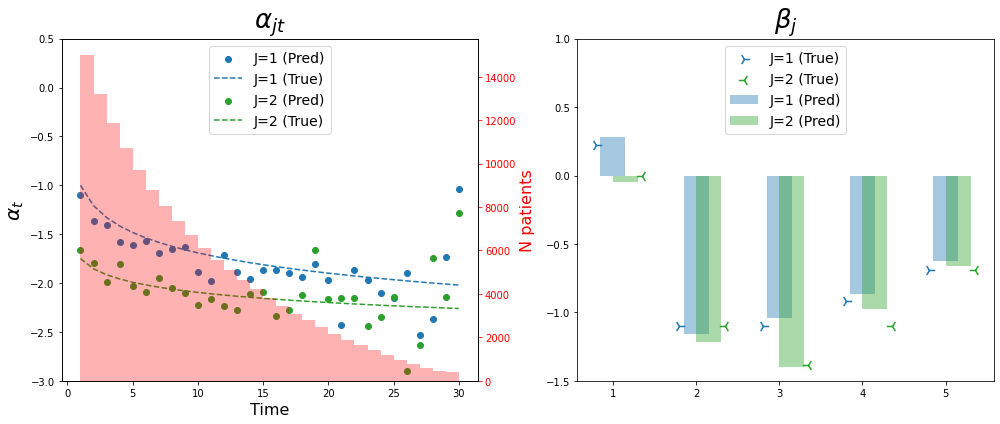

In [4]:
from pydts.examples_utils.plots import plot_first_model_coefs
plot_first_model_coefs(models=fitter.event_models, times=times, expanded_train_df=fitter.expanded_df, 
                       n_cov=5)

## New approach

Here, for each event, we first estimate $\beta_{j}$ using a time-stratified CoxPH model and the expanded data as we used in the previous approach. <br> <br>
Afterwards, we evaluate $\alpha_{jt}$ based on the original training data.

In [5]:
from pydts.fitters import TwoStagesFitter
fitter = TwoStagesFitter()
fitter.fit(df=train_df.drop(['C', 'T'], axis=1))
fitter.print_summary()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Model summary for event: 1


<lifelines.CoxPHFitter: fitted with 144115 total observations, 138841 right-censored observations>
             duration col = 'X'
                event col = 'j_1'
                   strata = X_copy
      baseline estimation = breslow
   number of observations = 144115
number of events observed = 5274
   partial log-likelihood = -46867.25
         time fit was run = 2022-03-08 14:14:18 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Z1          0.27       1.31       0.05             0.18             0.37                 1.20                 1.44
Z2         -1.13       0.32       0.05            -1.22            -1.03                 0.29                 0.36
Z3         -1.01       0.36       0.05            -1.11            -0.92                 0.33                 0.40
Z4         -0.84       0.43       0.05            -0.94            -0.75                 0.39                 0.47
Z5         -0.61       0.54       0.05            -0.70            -0.51                 0.50                 0.60

               z      p   -log2(p)
covariate                         
Z1          5.69 <0.005      26.27
Z2        -22.96 <0.005     385.07
Z3        -20.77 <0.005     316.02
Z4        -17.65 <0.005     229.23
Z5        -12.72 <0.005     120.73
---
Concordance = 0.64
Partial AIC = 93744.50
log-likelihood ratio test = 1364.04 on 5 df
-log2(p) of ll-ratio test = 970.23

None
    J   X  n_jt                                            opt_res  success  \
30  1   1   972  {'fun': 3.062944844903665e-10, 'jac': [2.36650...     True   
31  1   2   650  {'fun': 4.549080705602181e-11, 'jac': [6.92007...     True   
32  1   3   548  {'fun': 1.5371911613097864e-10, 'jac': [1.1949...     True   
33  1   4   414  {'fun': 3.66201216315859e-09, 'jac': [4.924538...     True   
34  1   5   357  {'fun': 6.726318949319695e-09, 'jac': [6.35775...     True   
35  1   6   330  {'fun': 5.6311829920815494e-09, 'jac': [5.8890...     True   
36  1   7   265  {'fun': 7.060960846216911e-11, 'jac': [5.81503...     True   
37  1   8   247  {'fun': 4.483530313293205e-11, 'jac': [4.72780...     True   
38  1   9   226  {'fun': 3.804446020679908e-11, 'jac': [4.38271...     True   
39  1  10   160  {'fun': 3.620383457778554e-09, 'jac': [3.34593...     True   
40  1  11   132  {'fun': 1.4209378934705598e-08, 'jac': [6.0079...     True   
41  1  12   154  {'fun': 3.3054203698865815e-10

<lifelines.CoxPHFitter: fitted with 144115 total observations, 141726 right-censored observations>
             duration col = 'X'
                event col = 'j_2'
                   strata = X_copy
      baseline estimation = breslow
   number of observations = 144115
number of events observed = 2389
   partial log-likelihood = -21040.09
         time fit was run = 2022-03-08 14:14:19 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Z1         -0.04       0.96       0.07            -0.18             0.10                 0.83                 1.10
Z2         -1.20       0.30       0.07            -1.35            -1.06                 0.26                 0.35
Z3         -1.39       0.25       0.07            -1.53            -1.24                 0.22                 0.29
Z4         -0.97       0.38       0.07            -1.11            -0.83                 0.33                 0.44
Z5         -0.65       0.52       0.07            -0.79            -0.51                 0.45                 0.60

               z      p   -log2(p)
covariate                         
Z1         -0.62   0.53       0.91
Z2        -16.45 <0.005     199.66
Z3        -18.83 <0.005     260.32
Z4        -13.58 <0.005     137.18
Z5         -9.17 <0.005      64.24
---
Concordance = 0.67
Partial AIC = 42090.18
log-likelihood ratio test = 839.50 on 5 df
-log2(p) of ll-ratio test = 592.91

None
    J   X  n_jt                                            opt_res  success  \
60  2   1   391  {'fun': 1.0894714687078257e-09, 'jac': [1.8849...     True   
61  2   2   293  {'fun': 1.086186407500435e-08, 'jac': [4.99989...     True   
62  2   3   212  {'fun': 9.249522223760055e-10, 'jac': [1.17551...     True   
63  2   4   223  {'fun': 1.8848186255182202e-08, 'jac': [6.1711...     True   
64  2   5   159  {'fun': 2.494780754636638e-09, 'jac': [1.76870...     True   
65  2   6   133  {'fun': 6.533457767072488e-09, 'jac': [2.63488...     True   
66  2   7   137  {'fun': 1.119238407191776e-09, 'jac': [1.22117...     True   
67  2   8   111  {'fun': 5.177964744000935e-09, 'jac': [2.34370...     True   
68  2   9    95  {'fun': 9.631432410171045e-09, 'jac': [3.01874...     True   
69  2  10    75  {'fun': 3.9384966025165283e-08, 'jac': [5.3243...     True   
70  2  11    72  {'fun': 2.3156828748619688e-08, 'jac': [4.2610...     True   
71  2  12    61  {'fun': 4.441064926248569e-08,

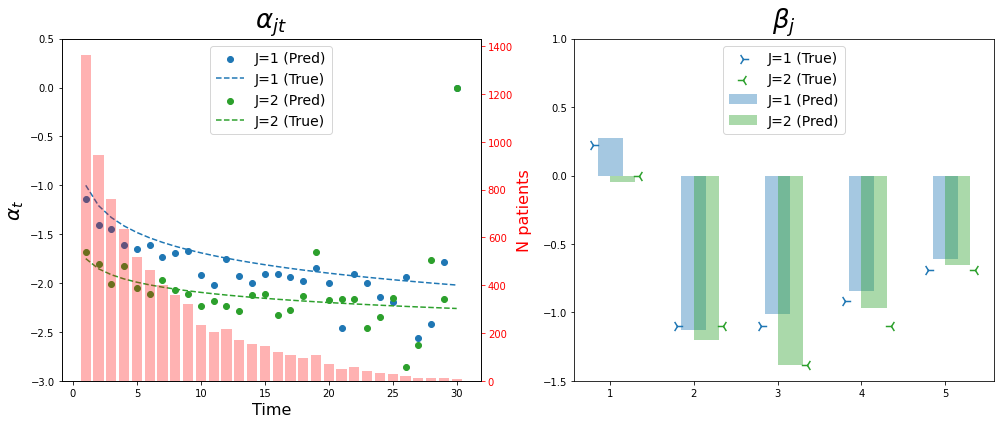

In [6]:
from pydts.examples_utils.plots import plot_second_model_coefs
plot_second_model_coefs(fitter.alpha_df, fitter.beta_models, times, n_cov=5)

## Comparison (WIP)

In [7]:
pd.DataFrame(index=['N=1000', 'N=10000', 'N=100000'], columns=['Train MSE (oracle)', 'Test MSE (oracle)', 'computation time'])

,Train MSE (oracle),Test MSE (oracle),computation time
N=1000,NaN,NaN,NaN
N=10000,NaN,NaN,NaN
N=100000,NaN,NaN,NaN
